In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
from datetime import datetime, timedelta
from scipy import spatial

C:\Users\slaye\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### This is our weather data. At the beginning there were more than 14 csv files of weather data. We concatenated all of them. Now it is called weather_data.

In [2]:
weather_data = pd.read_csv('weather_df.csv')

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\1021594493.py:1: DtypeWarning: Columns (23,24,29,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv('weather_df.csv')


In [3]:
weather_data.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

In [4]:
weather_data.columns

Index(['x', 'y', 'MAX_REL_HUMIDITY', 'TOTAL_SNOW_FLAG', 'LOCAL_DAY',
       'DIRECTION_MAX_GUST', 'ID', 'MEAN_TEMPERATURE', 'MIN_REL_HUMIDITY',
       'SNOW_ON_GROUND_FLAG', 'TOTAL_PRECIPITATION_FLAG', 'TOTAL_RAIN_FLAG',
       'HEATING_DEGREE_DAYS_FLAG', 'HEATING_DEGREE_DAYS', 'PROVINCE_CODE',
       'LOCAL_MONTH', 'TOTAL_RAIN', 'COOLING_DEGREE_DAYS',
       'MEAN_TEMPERATURE_FLAG', 'STATION_NAME', 'SPEED_MAX_GUST',
       'TOTAL_PRECIPITATION', 'CLIMATE_IDENTIFIER', 'MIN_REL_HUMIDITY_FLAG',
       'MIN_TEMPERATURE_FLAG', 'MAX_TEMPERATURE', 'COOLING_DEGREE_DAYS_FLAG',
       'LOCAL_YEAR', 'MAX_REL_HUMIDITY_FLAG', 'LOCAL_DATE', 'TOTAL_SNOW',
       'MIN_TEMPERATURE', 'SPEED_MAX_GUST_FLAG', 'DIRECTION_MAX_GUST_FLAG',
       'MAX_TEMPERATURE_FLAG', 'SNOW_ON_GROUND'],
      dtype='object')

### This is our wildfire data. It includes all wildfires from 1950-2021 from all provinces and territories of Canada.

In [5]:
wildfire_data = pd.read_csv('CANADA_WILDFIRES.csv')

In [6]:
wildfire_data.head()

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME
0,0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera
1,1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera
2,2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera
3,3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera
4,4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera


In [7]:
wildfire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423831 entries, 0 to 423830
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FID         423831 non-null  int64  
 1   SRC_AGENCY  423831 non-null  object 
 2   LATITUDE    423831 non-null  float64
 3   LONGITUDE   423831 non-null  float64
 4   REP_DATE    420118 non-null  object 
 5   SIZE_HA     423831 non-null  float64
 6   CAUSE       423590 non-null  object 
 7   PROTZONE    422821 non-null  object 
 8   ECOZ_NAME   423831 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 29.1+ MB


In [8]:
wildfire_data['REP_DATE']=pd.to_datetime(wildfire_data['REP_DATE'])

### We will only be interesting in Quebec wildfires between 2011-2021 caused by lightning. Lightning caused fires marked as 'L'. 

In [9]:
wildfire_QC = wildfire_data[(wildfire_data['SRC_AGENCY']=='QC') 
                            & (wildfire_data['REP_DATE'] > '2010-12-31') 
                            & (wildfire_data['CAUSE']=='L')]
wildfire_QC

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME
328420,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain
328421,328421,QC,52.5730,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain
328422,328422,QC,50.9285,-78.0518,2019-07-01,141.9,L,nordique,Hudson Plain
328423,328423,QC,52.6186,-76.6953,2018-06-28,3096.0,L,Nordique,Hudson Plain
328424,328424,QC,51.1331,-77.9800,2018-06-28,3006.4,L,Nordique,Hudson Plain
...,...,...,...,...,...,...,...,...,...
371481,371481,QC,46.8596,-79.0626,2021-08-29,0.0,L,Intensive,Boreal Shield East
371503,371503,QC,48.7468,-72.6749,2021-09-06,0.0,L,Intensive,Boreal Shield East
371510,371510,QC,45.9300,-77.2502,2021-09-06,0.7,L,Intensive,Boreal Shield East
371521,371521,QC,49.5292,-68.6923,2021-09-13,0.1,L,Intensive,Boreal Shield East


In [10]:
weather_data['LOCAL_DATE'] = pd.to_datetime(weather_data['LOCAL_DATE'])

### Here we create a column called Location in wildfire dataframe. This will be useful for us to determine the nearest weather station to a fire.

In [11]:
wildfire_QC['Location'] = wildfire_QC['LATITUDE'].astype(str) + ',' + wildfire_QC['LONGITUDE'].astype(str)
wildfire_QC

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\3811335443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_QC['Location'] = wildfire_QC['LATITUDE'].astype(str) + ',' + wildfire_QC['LONGITUDE'].astype(str)


,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,Location
328420,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"52.5747,-76.52129999999998"
328421,328421,QC,52.5730,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,"52.573,-76.54179999999998"
328422,328422,QC,50.9285,-78.0518,2019-07-01,141.9,L,nordique,Hudson Plain,"50.9285,-78.0518"
328423,328423,QC,52.6186,-76.6953,2018-06-28,3096.0,L,Nordique,Hudson Plain,"52.6186,-76.6953"
328424,328424,QC,51.1331,-77.9800,2018-06-28,3006.4,L,Nordique,Hudson Plain,"51.1331,-77.98"
...,...,...,...,...,...,...,...,...,...,...
371481,371481,QC,46.8596,-79.0626,2021-08-29,0.0,L,Intensive,Boreal Shield East,"46.8596,-79.0626"
371503,371503,QC,48.7468,-72.6749,2021-09-06,0.0,L,Intensive,Boreal Shield East,"48.7468,-72.67489999999998"
371510,371510,QC,45.9300,-77.2502,2021-09-06,0.7,L,Intensive,Boreal Shield East,"45.93,-77.2502"
371521,371521,QC,49.5292,-68.6923,2021-09-13,0.1,L,Intensive,Boreal Shield East,"49.5292,-68.6923"


In [12]:
duplicated_fires= wildfire_QC[wildfire_QC['Location'].duplicated()==True]
duplicated_fires

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,Location
367857,367857,QC,48.0658,-79.4181,2012-07-12,0.0,L,Intensive,Boreal Shield East,"48.0658,-79.41809999999998"
371415,371415,QC,47.4456,-78.4528,2021-08-11,0.0,L,Intensive,Boreal Shield East,"47.4456,-78.45279999999998"


### Here we see that there are 2 locations where the fires are duplicated. For the second location we see that the time difference is 2 year which is reasonable. For the first one time difference between the two is only 2 days. It is possible that the fire were put out on first day and then it reoccured because of a lightning. We can keep the first one. 

In [13]:
for location in duplicated_fires['Location']:
    loc_date_list = []
    loc_date_list.append(location)
    for date in wildfire_QC[wildfire_QC['Location']==location]['REP_DATE']:
        loc_date_list.append(date)
    print(loc_date_list)

['48.0658,-79.41809999999998', Timestamp('2012-07-14 00:00:00'), Timestamp('2012-07-12 00:00:00')]
['47.4456,-78.45279999999998', Timestamp('2019-07-29 00:00:00'), Timestamp('2021-08-11 00:00:00')]


In [14]:
wildfire_QC.drop_duplicates(subset = ['Location'], keep = 'first', inplace=True)

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\3213485522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_QC.drop_duplicates(subset = ['Location'], keep = 'first', inplace=True)


In [15]:
weather_data['Location'] = weather_data['y'].astype(str) + ',' + weather_data['x'].astype(str)

### We see that extreme coordinates of Quebec are: minimum longitude -79.76 and maximum longitude -57.10 and minimum latitude 44.99 and maximum latitude is 62.59 So we need to remove the ones that doesn't fit into this boundaries. 

https://en.wikipedia.org/wiki/Extreme_points_of_Canadian_provinces

In [16]:
weather_df1 = weather_data[(-79.76 < weather_data['x']) 
             & (weather_data['x'] < -57.10) 
             & (44.99< weather_data['y']) 
             & (weather_data['y']<62.59)]
weather_df1

,x,y,MAX_REL_HUMIDITY,TOTAL_SNOW_FLAG,LOCAL_DAY,DIRECTION_MAX_GUST,ID,MEAN_TEMPERATURE,MIN_REL_HUMIDITY,SNOW_ON_GROUND_FLAG,...,LOCAL_YEAR,MAX_REL_HUMIDITY_FLAG,LOCAL_DATE,TOTAL_SNOW,MIN_TEMPERATURE,SPEED_MAX_GUST_FLAG,DIRECTION_MAX_GUST_FLAG,MAX_TEMPERATURE_FLAG,SNOW_ON_GROUND,Location
1453,-71.013056,50.728889,80.0,M,1,NaN,7060826.2011.4.1,-8.3,42.0,NaN,...,2011,NaN,2011-04-01,NaN,-20.6,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1454,-71.013056,50.728889,82.0,M,2,NaN,7060826.2011.4.2,-2.0,19.0,NaN,...,2011,NaN,2011-04-02,NaN,-10.4,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1455,-71.013056,50.728889,80.0,M,3,NaN,7060826.2011.4.3,-7.4,29.0,NaN,...,2011,NaN,2011-04-03,NaN,-16.5,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1456,-71.013056,50.728889,93.0,M,4,NaN,7060826.2011.4.4,-8.5,41.0,NaN,...,2011,NaN,2011-04-04,NaN,-19.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1457,-71.013056,50.728889,95.0,M,5,NaN,7060826.2011.4.5,-3.1,71.0,NaN,...,2011,NaN,2011-04-05,NaN,-8.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745008,-76.050000,46.066667,NaN,T,26,NaN,7038975.2021.11.26,NaN,NaN,NaN,...,2021,NaN,2021-11-26,0.0,-4.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
745009,-76.050000,46.066667,NaN,NaN,27,NaN,7038975.2021.11.27,NaN,NaN,NaN,...,2021,NaN,2021-11-27,0.0,-9.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
745010,-76.050000,46.066667,NaN,NaN,28,NaN,7038975.2021.11.28,NaN,NaN,NaN,...,2021,NaN,2021-11-28,0.0,-15.2,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
745011,-76.050000,46.066667,NaN,NaN,29,NaN,7038975.2021.11.29,NaN,NaN,NaN,...,2021,NaN,2021-11-29,2.0,-10.4,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"


In [17]:
weather_df1_copy = weather_df1.copy()


In [18]:
weather_df = weather_df1_copy.reset_index()
weather_df

,index,x,y,MAX_REL_HUMIDITY,TOTAL_SNOW_FLAG,LOCAL_DAY,DIRECTION_MAX_GUST,ID,MEAN_TEMPERATURE,MIN_REL_HUMIDITY,...,LOCAL_YEAR,MAX_REL_HUMIDITY_FLAG,LOCAL_DATE,TOTAL_SNOW,MIN_TEMPERATURE,SPEED_MAX_GUST_FLAG,DIRECTION_MAX_GUST_FLAG,MAX_TEMPERATURE_FLAG,SNOW_ON_GROUND,Location
0,1453,-71.013056,50.728889,80.0,M,1,NaN,7060826.2011.4.1,-8.3,42.0,...,2011,NaN,2011-04-01,NaN,-20.6,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1,1454,-71.013056,50.728889,82.0,M,2,NaN,7060826.2011.4.2,-2.0,19.0,...,2011,NaN,2011-04-02,NaN,-10.4,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
2,1455,-71.013056,50.728889,80.0,M,3,NaN,7060826.2011.4.3,-7.4,29.0,...,2011,NaN,2011-04-03,NaN,-16.5,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
3,1456,-71.013056,50.728889,93.0,M,4,NaN,7060826.2011.4.4,-8.5,41.0,...,2011,NaN,2011-04-04,NaN,-19.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
4,1457,-71.013056,50.728889,95.0,M,5,NaN,7060826.2011.4.5,-3.1,71.0,...,2011,NaN,2011-04-05,NaN,-8.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743555,745008,-76.050000,46.066667,NaN,T,26,NaN,7038975.2021.11.26,NaN,NaN,...,2021,NaN,2021-11-26,0.0,-4.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743556,745009,-76.050000,46.066667,NaN,NaN,27,NaN,7038975.2021.11.27,NaN,NaN,...,2021,NaN,2021-11-27,0.0,-9.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743557,745010,-76.050000,46.066667,NaN,NaN,28,NaN,7038975.2021.11.28,NaN,NaN,...,2021,NaN,2021-11-28,0.0,-15.2,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743558,745011,-76.050000,46.066667,NaN,NaN,29,NaN,7038975.2021.11.29,NaN,NaN,...,2021,NaN,2021-11-29,2.0,-10.4,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"


In [19]:
weather_df.drop(columns = 'index', axis=1 , inplace = True)

### Now our aim is to match each fire with the nearest weather station. We have to put location into a same format.


In [20]:
weather_stations = weather_df['Location'].unique()
weather_stations

array(['50.72888888888889,-71.01305555555555',
       '48.471944444444446,-67.43472222222222',
       '46.016666666666666,-71.95', '45.65,-73.73333333333333',
       '46.66666666666666,-71.16666666666667', '45.4,-72.26666666666667',
       '45.18333333333333,-72.56666666666666', '45.48333333333333,-71.95',
       '59.29666666666667,-69.59972222222223',
       '60.81861111111111,-78.14861111111111', '45.55,-75.55',
       '45.95,-74.61666666666666', '48.85,-64.2',
       '48.333333333333336,-71.0', '46.70972222222223,-79.10111111111111',
       '47.07861111111111,-70.78083333333333',
       '48.37416666666667,-70.53527777777778',
       '49.27861111111111,-73.35555555555555',
       '47.28416666666666,-70.6375', '49.8225,-74.97527777777778',
       '46.46666666666667,-72.33333333333333',
       '45.31666666666667,-74.16666666666667',
       '49.77194444444444,-74.52805555555555', '45.15,-71.8',
       '45.81666666666667,-71.98333333333333',
       '48.30863166666666,-67.252525',
       

In [21]:
station_locations = []
for location in weather_stations:
    spl = location.split(',')
    station_locations.append((float(spl[0]),float(spl[1])))
station_locations

[(50.72888888888889, -71.01305555555555),
 (48.471944444444446, -67.43472222222222),
 (46.016666666666666, -71.95),
 (45.65, -73.73333333333333),
 (46.66666666666666, -71.16666666666667),
 (45.4, -72.26666666666667),
 (45.18333333333333, -72.56666666666666),
 (45.48333333333333, -71.95),
 (59.29666666666667, -69.59972222222223),
 (60.81861111111111, -78.14861111111111),
 (45.55, -75.55),
 (45.95, -74.61666666666666),
 (48.85, -64.2),
 (48.333333333333336, -71.0),
 (46.70972222222223, -79.10111111111111),
 (47.07861111111111, -70.78083333333333),
 (48.37416666666667, -70.53527777777778),
 (49.27861111111111, -73.35555555555555),
 (47.28416666666666, -70.6375),
 (49.8225, -74.97527777777778),
 (46.46666666666667, -72.33333333333333),
 (45.31666666666667, -74.16666666666667),
 (49.77194444444444, -74.52805555555555),
 (45.15, -71.8),
 (45.81666666666667, -71.98333333333333),
 (48.30863166666666, -67.252525),
 (49.77723833333334, -74.53029666666667),
 (45.68333333333333, -76.43333333333334

### To find nearest weather station we used spatial.KDTree() https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

### What this tree is doing is it takes weather stations' locations as nodes and when we 'query' a fire location to the tree it returns the nearest node using euclidean distance. 

In [22]:
tree = spatial.KDTree(station_locations)
tree

In [23]:
fires = wildfire_QC['Location']

In [24]:
fire_locations = []
for location in fires:
    spl = location.split(',')
    fire_locations.append((float(spl[0]),float(spl[1])))
fire_locations

[(52.5747, -76.52129999999998),
 (52.573, -76.54179999999998),
 (50.9285, -78.0518),
 (52.6186, -76.6953),
 (51.1331, -77.98),
 (51.6069, -77.9611),
 (51.5253, -78.1408),
 (52.7987, -77.33039999999998),
 (51.9045, -76.6534),
 (52.6636, -77.5092),
 (52.0128, -76.5689),
 (50.4564, -79.05939999999998),
 (51.771, -78.1346),
 (52.0333, -77.02639999999998),
 (50.1698, -79.51699999999998),
 (51.9708, -76.23999999999998),
 (52.2725, -76.4034),
 (51.5586, -79.4233),
 (49.1275, -65.2352),
 (48.5462, -66.9122),
 (48.1021, -67.4503),
 (49.1447, -64.896),
 (48.0979, -67.1951),
 (48.4262, -68.1989),
 (48.7306, -64.9126),
 (48.1506, -67.5234),
 (45.474, -72.51659999999998),
 (45.5691, -70.9462),
 (55.7317, -73.7886),
 (55.0289, -69.8711),
 (54.0469, -74.76139999999998),
 (54.815, -75.3606),
 (54.3803, -75.20529999999998),
 (54.0117, -75.21169999999998),
 (54.0514, -75.2753),
 (52.5563, -72.28919999999998),
 (52.744, -72.0346),
 (52.7784, -71.9815),
 (53.2608, -72.80469999999998),
 (53.977, -71.6269),

### Here we find nearest weather station to each fire.

In [25]:
fire_stations = []
for fire in fire_locations:
    prox_fire = tree.query([fire],p=2)
    fire_stations.append((tuple(fire), tuple(tree.data[prox_fire[1]][0])))
    print("Closest weather station to the fire", fire, "is", prox_fire[1])
fire_stations

Closest weather station to the fire (52.5747, -76.52129999999998) is [76]
Closest weather station to the fire (52.573, -76.54179999999998) is [76]
Closest weather station to the fire (50.9285, -78.0518) is [243]
Closest weather station to the fire (52.6186, -76.6953) is [76]
Closest weather station to the fire (51.1331, -77.98) is [243]
Closest weather station to the fire (51.6069, -77.9611) is [243]
Closest weather station to the fire (51.5253, -78.1408) is [243]
Closest weather station to the fire (52.7987, -77.33039999999998) is [76]
Closest weather station to the fire (51.9045, -76.6534) is [43]
Closest weather station to the fire (52.6636, -77.5092) is [76]
Closest weather station to the fire (52.0128, -76.5689) is [43]
Closest weather station to the fire (50.4564, -79.05939999999998) is [243]
Closest weather station to the fire (51.771, -78.1346) is [43]
Closest weather station to the fire (52.0333, -77.02639999999998) is [43]
Closest weather station to the fire (50.1698, -79.516

Closest weather station to the fire (52.0942, -76.2236) is [76]
Closest weather station to the fire (52.0933, -76.21779999999998) is [76]
Closest weather station to the fire (52.6786, -76.1744) is [76]
Closest weather station to the fire (52.5478, -76.21609999999998) is [76]
Closest weather station to the fire (52.615, -76.45279999999998) is [76]
Closest weather station to the fire (52.6267, -78.3664) is [43]
Closest weather station to the fire (51.8622, -76.42279999999998) is [43]
Closest weather station to the fire (51.6194, -77.8617) is [43]
Closest weather station to the fire (51.1661, -77.4397) is [243]
Closest weather station to the fire (52.0164, -76.6653) is [43]
Closest weather station to the fire (52.4117, -78.2994) is [43]
Closest weather station to the fire (52.2853, -76.0672) is [76]
Closest weather station to the fire (50.4028, -79.30939999999998) is [243]
Closest weather station to the fire (51.2861, -78.375) is [243]
Closest weather station to the fire (52.1094, -76.435

Closest weather station to the fire (49.7736, -68.1733) is [106]
Closest weather station to the fire (50.6267, -68.5097) is [106]
Closest weather station to the fire (50.5172, -67.9167) is [51]
Closest weather station to the fire (50.555, -68.4111) is [106]
Closest weather station to the fire (50.6058, -68.4419) is [106]
Closest weather station to the fire (50.6786, -68.3728) is [51]
Closest weather station to the fire (50.1992, -72.0497) is [33]
Closest weather station to the fire (50.1222, -70.0133) is [115]
Closest weather station to the fire (49.9367, -70.05) is [115]
Closest weather station to the fire (49.8514, -70.0178) is [115]
Closest weather station to the fire (50.1572, -70.7008) is [115]
Closest weather station to the fire (49.7636, -70.4472) is [33]
Closest weather station to the fire (49.5889, -69.9806) is [115]
Closest weather station to the fire (50.0506, -70.755) is [33]
Closest weather station to the fire (49.9781, -72.7458) is [17]
Closest weather station to the fire

Closest weather station to the fire (46.9708, -73.5056) is [225]
Closest weather station to the fire (46.7028, -73.4989) is [183]
Closest weather station to the fire (46.8369, -72.2239) is [96]
Closest weather station to the fire (46.0136, -75.70999999999998) is [58]
Closest weather station to the fire (46.2056, -75.69169999999998) is [124]
Closest weather station to the fire (45.6258, -76.30889999999998) is [27]
Closest weather station to the fire (45.5828, -76.1333) is [123]
Closest weather station to the fire (45.6892, -75.2372) is [29]
Closest weather station to the fire (46.0083, -75.7817) is [58]
Closest weather station to the fire (46.3678, -75.6589) is [126]
Closest weather station to the fire (45.5614, -75.84359999999998) is [28]
Closest weather station to the fire (46.2997, -75.64579999999998) is [126]
Closest weather station to the fire (46.3775, -75.39329999999998) is [126]
Closest weather station to the fire (45.7433, -76.4886) is [27]
Closest weather station to the fire (

[((52.5747, -76.52129999999998), (53.625277777777775, -77.70416666666667)),
 ((52.573, -76.54179999999998), (53.625277777777775, -77.70416666666667)),
 ((50.9285, -78.0518), (51.473333333333336, -78.75833333333334)),
 ((52.6186, -76.6953), (53.625277777777775, -77.70416666666667)),
 ((51.1331, -77.98), (51.473333333333336, -78.75833333333334)),
 ((51.6069, -77.9611), (51.473333333333336, -78.75833333333334)),
 ((51.5253, -78.1408), (51.473333333333336, -78.75833333333334)),
 ((52.7987, -77.33039999999998), (53.625277777777775, -77.70416666666667)),
 ((51.9045, -76.6534), (52.22638888888889, -78.5225)),
 ((52.6636, -77.5092), (53.625277777777775, -77.70416666666667)),
 ((52.0128, -76.5689), (52.22638888888889, -78.5225)),
 ((50.4564, -79.05939999999998), (51.473333333333336, -78.75833333333334)),
 ((51.771, -78.1346), (52.22638888888889, -78.5225)),
 ((52.0333, -77.02639999999998), (52.22638888888889, -78.5225)),
 ((50.1698, -79.51699999999998), (51.473333333333336, -78.75833333333334))

In [26]:
fire_station_df = pd.DataFrame(fire_stations, columns = ['FireLocation', 'WeatherLocation'])
fire_station_df

,FireLocation,WeatherLocation
0,"(52.5747, -76.52129999999998)","(53.625277777777775, -77.70416666666667)"
1,"(52.573, -76.54179999999998)","(53.625277777777775, -77.70416666666667)"
2,"(50.9285, -78.0518)","(51.473333333333336, -78.75833333333334)"
3,"(52.6186, -76.6953)","(53.625277777777775, -77.70416666666667)"
4,"(51.1331, -77.98)","(51.473333333333336, -78.75833333333334)"
...,...,...
1404,"(46.8596, -79.0626)","(46.70972222222223, -79.10111111111111)"
1405,"(48.7468, -72.67489999999998)","(48.84166666666667, -72.54694444444445)"
1406,"(45.93, -77.2502)","(45.96666666666667, -77.25)"
1407,"(49.5292, -68.6923)","(49.11666666666667, -68.38333333333334)"


### We create a new column which contains a formatted version of weather stations' locations and fire locations that will be useful for us to merge dataframes in the following steps. 

In [27]:
fire_weather_df = fire_station_df.astype({'FireLocation':str, 'WeatherLocation': str}).assign(Location = lambda df : df['FireLocation'].str.replace('\(|\)| ', ''))
fire_weather_df

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\3851688460.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  fire_weather_df = fire_station_df.astype({'FireLocation':str, 'WeatherLocation': str}).assign(Location = lambda df : df['FireLocation'].str.replace('\(|\)| ', ''))


,FireLocation,WeatherLocation,Location
0,"(52.5747, -76.52129999999998)","(53.625277777777775, -77.70416666666667)","52.5747,-76.52129999999998"
1,"(52.573, -76.54179999999998)","(53.625277777777775, -77.70416666666667)","52.573,-76.54179999999998"
2,"(50.9285, -78.0518)","(51.473333333333336, -78.75833333333334)","50.9285,-78.0518"
3,"(52.6186, -76.6953)","(53.625277777777775, -77.70416666666667)","52.6186,-76.6953"
4,"(51.1331, -77.98)","(51.473333333333336, -78.75833333333334)","51.1331,-77.98"
...,...,...,...
1404,"(46.8596, -79.0626)","(46.70972222222223, -79.10111111111111)","46.8596,-79.0626"
1405,"(48.7468, -72.67489999999998)","(48.84166666666667, -72.54694444444445)","48.7468,-72.67489999999998"
1406,"(45.93, -77.2502)","(45.96666666666667, -77.25)","45.93,-77.2502"
1407,"(49.5292, -68.6923)","(49.11666666666667, -68.38333333333334)","49.5292,-68.6923"


In [28]:
fire_weather_df2 = fire_weather_df.astype({'FireLocation':str, 'WeatherLocation': str}).assign(Location2 = lambda df : df['WeatherLocation'].str.replace('\(|\)| ', ''))
fire_weather_df2

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\3334070739.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  fire_weather_df2 = fire_weather_df.astype({'FireLocation':str, 'WeatherLocation': str}).assign(Location2 = lambda df : df['WeatherLocation'].str.replace('\(|\)| ', ''))


,FireLocation,WeatherLocation,Location,Location2
0,"(52.5747, -76.52129999999998)","(53.625277777777775, -77.70416666666667)","52.5747,-76.52129999999998","53.625277777777775,-77.70416666666667"
1,"(52.573, -76.54179999999998)","(53.625277777777775, -77.70416666666667)","52.573,-76.54179999999998","53.625277777777775,-77.70416666666667"
2,"(50.9285, -78.0518)","(51.473333333333336, -78.75833333333334)","50.9285,-78.0518","51.473333333333336,-78.75833333333334"
3,"(52.6186, -76.6953)","(53.625277777777775, -77.70416666666667)","52.6186,-76.6953","53.625277777777775,-77.70416666666667"
4,"(51.1331, -77.98)","(51.473333333333336, -78.75833333333334)","51.1331,-77.98","51.473333333333336,-78.75833333333334"
...,...,...,...,...
1404,"(46.8596, -79.0626)","(46.70972222222223, -79.10111111111111)","46.8596,-79.0626","46.70972222222223,-79.10111111111111"
1405,"(48.7468, -72.67489999999998)","(48.84166666666667, -72.54694444444445)","48.7468,-72.67489999999998","48.84166666666667,-72.54694444444445"
1406,"(45.93, -77.2502)","(45.96666666666667, -77.25)","45.93,-77.2502","45.96666666666667,-77.25"
1407,"(49.5292, -68.6923)","(49.11666666666667, -68.38333333333334)","49.5292,-68.6923","49.11666666666667,-68.38333333333334"


### After matching each fire with the weather stations' locations, we have to decide how many days is needed for prediction prior to fire. In the following article where they use same features as we do, they suggest to use 15 days prior to a fire.

https://www.researchgate.net/publication/258845568_Predicting_fire_occurrence_patterns_with_logistic_regression_in_Heilongjiang_Province_China

In [29]:
#This function returns all dates within a date and 15 days before that date. 
def days15(myDateStr):
    datelist=[]
    #converting to datetime 
    date = pd.to_datetime(myDateStr)
    #loop to create 15 datetimes
    for i in range(15):
        newdate = date - timedelta(days=i)
    #adding new dates to the list
        datelist.append(newdate)
    return datelist

### Here we find fire locations where there is no available weather data as it is simply because the nearest weather station is not providing weather data for that date. When doing that, we wanted the nearest weather station to provide at least 11 days of weather data before the fire date so that we can fill the NaN values as there will be a few if any. 

In [30]:
fires_notin_weather=[]
for fire_loc in fire_weather_df2['Location'].tolist():
    for weat_loc in fire_weather_df2[fire_weather_df2['Location']==fire_loc]['Location2']:
        fire_15=days15(wildfire_QC[wildfire_QC['Location']==fire_loc]['REP_DATE'].tolist()[0])
        weat_dates=weather_df[weather_df['Location']==weat_loc]['LOCAL_DATE'].tolist()
        L=[date for date in fire_15 if date in weat_dates]
        if len(L)<11:
            fires_notin_weather.append(fire_loc)
        #if wildfire_QC[wildfire_QC['Location']==fire_loc]['REP_DATE'].tolist()[0] not in weather_df[weather_df['Location']==weat_loc]['LOCAL_DATE'].tolist():
        #   fires_notin_weather.append(fire_loc)
fires_notin_weather

['51.1331,-77.98',
 '51.6069,-77.9611',
 '51.5253,-78.1408',
 '51.9045,-76.6534',
 '52.0128,-76.5689',
 '50.4564,-79.05939999999998',
 '51.771,-78.1346',
 '52.0333,-77.02639999999998',
 '50.1698,-79.51699999999998',
 '51.5586,-79.4233',
 '45.5691,-70.9462',
 '55.7317,-73.7886',
 '54.0469,-74.76139999999998',
 '54.815,-75.3606',
 '54.3803,-75.20529999999998',
 '54.0117,-75.21169999999998',
 '54.0514,-75.2753',
 '53.2608,-72.80469999999998',
 '53.977,-71.6269',
 '53.7478,-72.1014',
 '53.5042,-74.7613',
 '53.7054,-72.7604',
 '51.955,-63.6117',
 '51.8961,-63.403',
 '51.8088,-63.0792',
 '52.9239,-75.5536',
 '52.8186,-73.9628',
 '52.5906,-75.6222',
 '52.6247,-75.5567',
 '52.4887,-74.92019999999998',
 '52.5019,-74.8739',
 '52.5297,-74.83039999999998',
 '52.2833,-72.9839',
 '52.3167,-72.90059999999998',
 '51.6479,-63.8619',
 '49.9366,-67.3847',
 '50.6716,-66.1876',
 '50.3875,-79.0128',
 '50.3711,-79.0031',
 '50.0369,-79.4272',
 '50.3258,-78.9944',
 '49.5887,-74.7016',
 '49.6789,-74.3227',
 '49

In [31]:
len(fires_notin_weather) #323 fires have no weather data available. 

323

In [32]:
index_list=[]
for loc in fires_notin_weather:
    index_list.append(fire_weather_df2[fire_weather_df2['Location']==loc].index)
index_list

[Int64Index([4], dtype='int64'),
 Int64Index([5], dtype='int64'),
 Int64Index([6], dtype='int64'),
 Int64Index([8], dtype='int64'),
 Int64Index([10], dtype='int64'),
 Int64Index([11], dtype='int64'),
 Int64Index([12], dtype='int64'),
 Int64Index([13], dtype='int64'),
 Int64Index([14], dtype='int64'),
 Int64Index([17], dtype='int64'),
 Int64Index([27], dtype='int64'),
 Int64Index([28], dtype='int64'),
 Int64Index([30], dtype='int64'),
 Int64Index([31], dtype='int64'),
 Int64Index([32], dtype='int64'),
 Int64Index([33], dtype='int64'),
 Int64Index([34], dtype='int64'),
 Int64Index([38], dtype='int64'),
 Int64Index([39], dtype='int64'),
 Int64Index([40], dtype='int64'),
 Int64Index([41], dtype='int64'),
 Int64Index([42], dtype='int64'),
 Int64Index([49], dtype='int64'),
 Int64Index([50], dtype='int64'),
 Int64Index([51], dtype='int64'),
 Int64Index([55], dtype='int64'),
 Int64Index([56], dtype='int64'),
 Int64Index([57], dtype='int64'),
 Int64Index([58], dtype='int64'),
 Int64Index([60], 

In [33]:
fire_weather_df2_copy=fire_weather_df2.copy()
for index in index_list:
    fire_weather_df2_copy.drop(index,axis=0,inplace=True)
fire_weather_df2_copy

,FireLocation,WeatherLocation,Location,Location2
0,"(52.5747, -76.52129999999998)","(53.625277777777775, -77.70416666666667)","52.5747,-76.52129999999998","53.625277777777775,-77.70416666666667"
1,"(52.573, -76.54179999999998)","(53.625277777777775, -77.70416666666667)","52.573,-76.54179999999998","53.625277777777775,-77.70416666666667"
2,"(50.9285, -78.0518)","(51.473333333333336, -78.75833333333334)","50.9285,-78.0518","51.473333333333336,-78.75833333333334"
3,"(52.6186, -76.6953)","(53.625277777777775, -77.70416666666667)","52.6186,-76.6953","53.625277777777775,-77.70416666666667"
7,"(52.7987, -77.33039999999998)","(53.625277777777775, -77.70416666666667)","52.7987,-77.33039999999998","53.625277777777775,-77.70416666666667"
...,...,...,...,...
1403,"(49.3493, -72.69339999999998)","(48.84166666666667, -72.54694444444445)","49.3493,-72.69339999999998","48.84166666666667,-72.54694444444445"
1404,"(46.8596, -79.0626)","(46.70972222222223, -79.10111111111111)","46.8596,-79.0626","46.70972222222223,-79.10111111111111"
1405,"(48.7468, -72.67489999999998)","(48.84166666666667, -72.54694444444445)","48.7468,-72.67489999999998","48.84166666666667,-72.54694444444445"
1407,"(49.5292, -68.6923)","(49.11666666666667, -68.38333333333334)","49.5292,-68.6923","49.11666666666667,-68.38333333333334"


In [34]:
fire_weather_df3=fire_weather_df2_copy.reset_index()

In [35]:
fire_weather_df3.drop("index",axis=1,inplace=True)

### Now we merge two dataframes. One is wildfire data the other is that contains fire location and nearest weather station location. 

In [36]:
merged_df=wildfire_QC.merge(fire_weather_df3, how = 'right', on = 'Location')
merged_df['PROTZONE'] = merged_df['PROTZONE'].str.lower()
merged_df

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,Location,FireLocation,WeatherLocation,Location2
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"52.5747,-76.52129999999998","(52.5747, -76.52129999999998)","(53.625277777777775, -77.70416666666667)","53.625277777777775,-77.70416666666667"
1,328421,QC,52.5730,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,"52.573,-76.54179999999998","(52.573, -76.54179999999998)","(53.625277777777775, -77.70416666666667)","53.625277777777775,-77.70416666666667"
2,328422,QC,50.9285,-78.0518,2019-07-01,141.9,L,nordique,Hudson Plain,"50.9285,-78.0518","(50.9285, -78.0518)","(51.473333333333336, -78.75833333333334)","51.473333333333336,-78.75833333333334"
3,328423,QC,52.6186,-76.6953,2018-06-28,3096.0,L,nordique,Hudson Plain,"52.6186,-76.6953","(52.6186, -76.6953)","(53.625277777777775, -77.70416666666667)","53.625277777777775,-77.70416666666667"
4,328427,QC,52.7987,-77.3304,2018-07-05,6.3,L,nordique,Taiga Shield East,"52.7987,-77.33039999999998","(52.7987, -77.33039999999998)","(53.625277777777775, -77.70416666666667)","53.625277777777775,-77.70416666666667"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,371479,QC,49.3493,-72.6934,2021-08-26,0.0,L,intensive,Boreal Shield East,"49.3493,-72.69339999999998","(49.3493, -72.69339999999998)","(48.84166666666667, -72.54694444444445)","48.84166666666667,-72.54694444444445"
1082,371481,QC,46.8596,-79.0626,2021-08-29,0.0,L,intensive,Boreal Shield East,"46.8596,-79.0626","(46.8596, -79.0626)","(46.70972222222223, -79.10111111111111)","46.70972222222223,-79.10111111111111"
1083,371503,QC,48.7468,-72.6749,2021-09-06,0.0,L,intensive,Boreal Shield East,"48.7468,-72.67489999999998","(48.7468, -72.67489999999998)","(48.84166666666667, -72.54694444444445)","48.84166666666667,-72.54694444444445"
1084,371521,QC,49.5292,-68.6923,2021-09-13,0.1,L,intensive,Boreal Shield East,"49.5292,-68.6923","(49.5292, -68.6923)","(49.11666666666667, -68.38333333333334)","49.11666666666667,-68.38333333333334"


In [37]:
merged_df['WeatherLocation'] = merged_df['WeatherLocation'].apply(lambda x : x.replace('(','').replace(')',''))
merged_df


,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,Location,FireLocation,WeatherLocation,Location2
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"52.5747,-76.52129999999998","(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667","53.625277777777775,-77.70416666666667"
1,328421,QC,52.5730,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,"52.573,-76.54179999999998","(52.573, -76.54179999999998)","53.625277777777775, -77.70416666666667","53.625277777777775,-77.70416666666667"
2,328422,QC,50.9285,-78.0518,2019-07-01,141.9,L,nordique,Hudson Plain,"50.9285,-78.0518","(50.9285, -78.0518)","51.473333333333336, -78.75833333333334","51.473333333333336,-78.75833333333334"
3,328423,QC,52.6186,-76.6953,2018-06-28,3096.0,L,nordique,Hudson Plain,"52.6186,-76.6953","(52.6186, -76.6953)","53.625277777777775, -77.70416666666667","53.625277777777775,-77.70416666666667"
4,328427,QC,52.7987,-77.3304,2018-07-05,6.3,L,nordique,Taiga Shield East,"52.7987,-77.33039999999998","(52.7987, -77.33039999999998)","53.625277777777775, -77.70416666666667","53.625277777777775,-77.70416666666667"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,371479,QC,49.3493,-72.6934,2021-08-26,0.0,L,intensive,Boreal Shield East,"49.3493,-72.69339999999998","(49.3493, -72.69339999999998)","48.84166666666667, -72.54694444444445","48.84166666666667,-72.54694444444445"
1082,371481,QC,46.8596,-79.0626,2021-08-29,0.0,L,intensive,Boreal Shield East,"46.8596,-79.0626","(46.8596, -79.0626)","46.70972222222223, -79.10111111111111","46.70972222222223,-79.10111111111111"
1083,371503,QC,48.7468,-72.6749,2021-09-06,0.0,L,intensive,Boreal Shield East,"48.7468,-72.67489999999998","(48.7468, -72.67489999999998)","48.84166666666667, -72.54694444444445","48.84166666666667,-72.54694444444445"
1084,371521,QC,49.5292,-68.6923,2021-09-13,0.1,L,intensive,Boreal Shield East,"49.5292,-68.6923","(49.5292, -68.6923)","49.11666666666667, -68.38333333333334","49.11666666666667,-68.38333333333334"


In [38]:
merged_df.drop("Location2",axis=1,inplace=True)


In [39]:
merged_df.drop(columns = 'Location', axis =1, inplace=True)

### Now we repeat each row 15 times so that we can fill those with corresponding weather data. 

In [40]:
merged_df_new = pd.DataFrame(np.repeat(merged_df.values, 15, axis=0))
merged_df_new.columns = merged_df.columns
merged_df_new

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,WeatherLocation
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
1,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
2,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
3,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
4,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
...,...,...,...,...,...,...,...,...,...,...,...
16285,371525,QC,47.0126,-71.5198,2021-10-02,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16286,371525,QC,47.0126,-71.5198,2021-10-02,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16287,371525,QC,47.0126,-71.5198,2021-10-02,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16288,371525,QC,47.0126,-71.5198,2021-10-02,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"


### Now we replace repeated days with function days15() defined above so that each 15 rows has consecutive 15 days. 

In [41]:
start = 0
end = 14
for j in range(len(merged_df)):
    date = pd.to_datetime(merged_df['REP_DATE'][j])
    new_dates = days15(date)
    merged_df_new['REP_DATE'][start:end+1] = new_dates
    start=start+15
    end=end+15
merged_df_new    

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\3185150954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_new['REP_DATE'][start:end+1] = new_dates


,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,WeatherLocation
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
1,328420,QC,52.5747,-76.5213,2019-06-30,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
2,328420,QC,52.5747,-76.5213,2019-06-29,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
3,328420,QC,52.5747,-76.5213,2019-06-28,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
4,328420,QC,52.5747,-76.5213,2019-06-27,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775, -77.70416666666667"
...,...,...,...,...,...,...,...,...,...,...,...
16285,371525,QC,47.0126,-71.5198,2021-09-22,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16286,371525,QC,47.0126,-71.5198,2021-09-21,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16287,371525,QC,47.0126,-71.5198,2021-09-20,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"
16288,371525,QC,47.0126,-71.5198,2021-09-19,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778, -71.50361111111111"


In [42]:
weather_df['LOCAL_DATE']=pd.to_datetime(weather_df['LOCAL_DATE'])
weather_df

,x,y,MAX_REL_HUMIDITY,TOTAL_SNOW_FLAG,LOCAL_DAY,DIRECTION_MAX_GUST,ID,MEAN_TEMPERATURE,MIN_REL_HUMIDITY,SNOW_ON_GROUND_FLAG,...,LOCAL_YEAR,MAX_REL_HUMIDITY_FLAG,LOCAL_DATE,TOTAL_SNOW,MIN_TEMPERATURE,SPEED_MAX_GUST_FLAG,DIRECTION_MAX_GUST_FLAG,MAX_TEMPERATURE_FLAG,SNOW_ON_GROUND,Location
0,-71.013056,50.728889,80.0,M,1,NaN,7060826.2011.4.1,-8.3,42.0,NaN,...,2011,NaN,2011-04-01,NaN,-20.6,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
1,-71.013056,50.728889,82.0,M,2,NaN,7060826.2011.4.2,-2.0,19.0,NaN,...,2011,NaN,2011-04-02,NaN,-10.4,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
2,-71.013056,50.728889,80.0,M,3,NaN,7060826.2011.4.3,-7.4,29.0,NaN,...,2011,NaN,2011-04-03,NaN,-16.5,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
3,-71.013056,50.728889,93.0,M,4,NaN,7060826.2011.4.4,-8.5,41.0,NaN,...,2011,NaN,2011-04-04,NaN,-19.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
4,-71.013056,50.728889,95.0,M,5,NaN,7060826.2011.4.5,-3.1,71.0,NaN,...,2011,NaN,2011-04-05,NaN,-8.0,M,M,NaN,NaN,"50.72888888888889,-71.01305555555555"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743555,-76.050000,46.066667,NaN,T,26,NaN,7038975.2021.11.26,NaN,NaN,NaN,...,2021,NaN,2021-11-26,0.0,-4.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743556,-76.050000,46.066667,NaN,NaN,27,NaN,7038975.2021.11.27,NaN,NaN,NaN,...,2021,NaN,2021-11-27,0.0,-9.0,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743557,-76.050000,46.066667,NaN,NaN,28,NaN,7038975.2021.11.28,NaN,NaN,NaN,...,2021,NaN,2021-11-28,0.0,-15.2,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"
743558,-76.050000,46.066667,NaN,NaN,29,NaN,7038975.2021.11.29,NaN,NaN,NaN,...,2021,NaN,2021-11-29,2.0,-10.4,NaN,NaN,NaN,0.0,"46.06666666666667,-76.05"


In [43]:
merged_df_new=merged_df_new.assign(WeatherLocation = lambda df : df['WeatherLocation'].str.replace(' ',''))
merged_df_new

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,WeatherLocation
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775,-77.70416666666667"
1,328420,QC,52.5747,-76.5213,2019-06-30,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775,-77.70416666666667"
2,328420,QC,52.5747,-76.5213,2019-06-29,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775,-77.70416666666667"
3,328420,QC,52.5747,-76.5213,2019-06-28,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775,-77.70416666666667"
4,328420,QC,52.5747,-76.5213,2019-06-27,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)","53.625277777777775,-77.70416666666667"
...,...,...,...,...,...,...,...,...,...,...,...
16285,371525,QC,47.0126,-71.5198,2021-09-22,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778,-71.50361111111111"
16286,371525,QC,47.0126,-71.5198,2021-09-21,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778,-71.50361111111111"
16287,371525,QC,47.0126,-71.5198,2021-09-20,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778,-71.50361111111111"
16288,371525,QC,47.0126,-71.5198,2021-09-19,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)","46.90277777777778,-71.50361111111111"


In [44]:
weather_df = weather_df.rename(columns={"Location": "WeatherLocation", "LOCAL_DATE": "REP_DATE"})

### Here we merge the dataframe that has 15 rows for each fire with adjusted dates with weather data on weather stations' location and date. 

In [45]:
merged_df2=merged_df_new.merge(weather_df, how = 'left', on = ['WeatherLocation','REP_DATE'])
merged_df2

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,...,MAX_TEMPERATURE,COOLING_DEGREE_DAYS_FLAG,LOCAL_YEAR,MAX_REL_HUMIDITY_FLAG,TOTAL_SNOW,MIN_TEMPERATURE,SPEED_MAX_GUST_FLAG,DIRECTION_MAX_GUST_FLAG,MAX_TEMPERATURE_FLAG,SNOW_ON_GROUND
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,23.2,NaN,2019.0,NaN,0.0,10.7,NaN,NaN,NaN,NaN
1,328420,QC,52.5747,-76.5213,2019-06-30,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,23.9,NaN,2019.0,NaN,0.0,9.4,NaN,NaN,NaN,NaN
2,328420,QC,52.5747,-76.5213,2019-06-29,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,21.6,NaN,2019.0,NaN,0.0,10.1,NaN,NaN,NaN,NaN
3,328420,QC,52.5747,-76.5213,2019-06-28,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,18.3,NaN,2019.0,NaN,0.0,10.0,NaN,NaN,NaN,NaN
4,328420,QC,52.5747,-76.5213,2019-06-27,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,16.8,NaN,2019.0,NaN,0.0,11.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,371525,QC,47.0126,-71.5198,2021-09-22,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)",...,20.0,NaN,2021.0,NaN,NaN,7.5,M,M,NaN,NaN
17021,371525,QC,47.0126,-71.5198,2021-09-21,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)",...,23.3,NaN,2021.0,NaN,NaN,5.9,M,M,NaN,NaN
17022,371525,QC,47.0126,-71.5198,2021-09-20,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)",...,NaN,M,2021.0,M,NaN,NaN,M,M,M,NaN
17023,371525,QC,47.0126,-71.5198,2021-09-19,0.7,L,intensive,Boreal Shield East,"(47.0126, -71.5198)",...,19.8,NaN,2021.0,NaN,NaN,4.8,M,M,NaN,NaN


### We check NaN values. Yellows represent NaN values. 

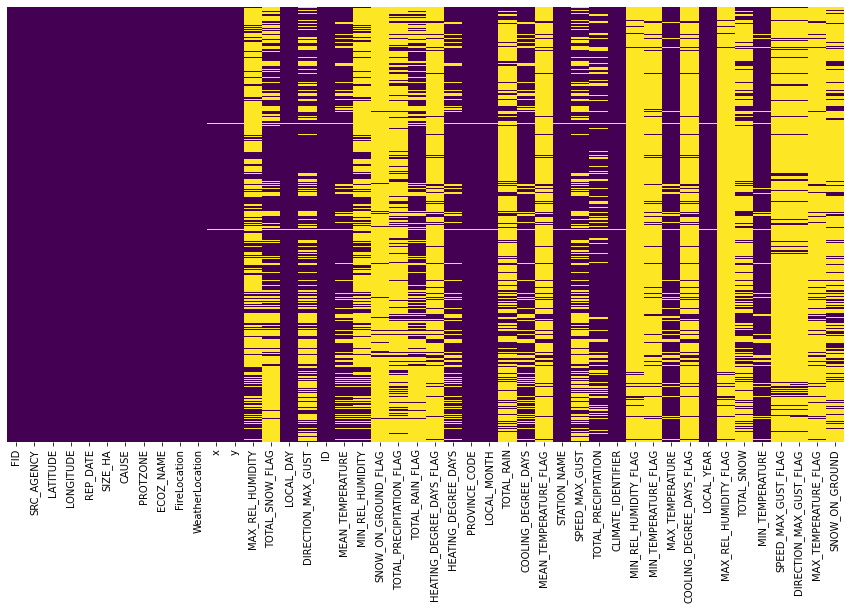

In [46]:
plt.figure(figsize=(15,8))
ax =sns.heatmap(merged_df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [47]:
percent_missing = merged_df2.isnull().sum() * 100 / len(merged_df2)
missing_value_df = pd.DataFrame({'column_name': merged_df2.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

### We find percentage of NaN values in each column. Some of the columns have really high percentage for example the ones with the tag 'FLAG'. This is a regular application because flags are to put when a special condition occurs. 

In [48]:
missing_value_df

,column_name,percent_missing
FID,FID,0.000000
WeatherLocation,WeatherLocation,0.000000
ECOZ_NAME,ECOZ_NAME,0.000000
PROTZONE,PROTZONE,0.000000
CAUSE,CAUSE,0.000000
FireLocation,FireLocation,0.000000
REP_DATE,REP_DATE,0.000000
LONGITUDE,LONGITUDE,0.000000
LATITUDE,LATITUDE,0.000000
SRC_AGENCY,SRC_AGENCY,0.000000


### There are 6 variables that holds a high importance for us. These are minimum and maximum relative humidity, minimum, maximum and mean temperature, direction and speed of gust. So we want to work on those data where these features has less NaN values. This is also mentioned in some of the articles we read. 

https://d1ied5g1xfgpx8.cloudfront.net/pdfs/10706.pdf

https://www.researchgate.net/publication/258845568_Predicting_fire_occurrence_patterns_with_logistic_regression_in_Heilongjiang_Province_China

https://iopscience.iop.org/article/10.1088/1742-6596/1566/1/012002/pdf

In [49]:
fid_list = merged_df2[(merged_df2['MIN_REL_HUMIDITY'].isna() == False) &
            (merged_df2['MAX_REL_HUMIDITY'].isna() == False) &
            (merged_df2['MAX_TEMPERATURE'].isna()==False) &
           (merged_df2['MIN_TEMPERATURE'].isna()==False) &
           (merged_df2['DIRECTION_MAX_GUST'].isna()==False) &
           (merged_df2['SPEED_MAX_GUST'].isna()==False)]['FID'].unique()
fid_15_list=[]
for fid in fid_list:
    if len(merged_df2[(merged_df2['MIN_REL_HUMIDITY'].isna() == False) &
            (merged_df2['MAX_REL_HUMIDITY'].isna() == False) &
            (merged_df2['MAX_TEMPERATURE'].isna()==False) &
           (merged_df2['MIN_TEMPERATURE'].isna()==False) &
           (merged_df2['DIRECTION_MAX_GUST'].isna()==False) &
           (merged_df2['SPEED_MAX_GUST'].isna()==False) &
              (merged_df2['FID']==fid)])>8:
        fid_15_list.append(fid)

In [50]:
len(fid_15_list) #There are 257 fires as such. 

257

In [51]:
to_remove_index=[]
for index in merged_df2.index:
    if merged_df2.loc[index]['FID'] not in fid_15_list:
        to_remove_index.append(index)

In [52]:
merged_df2.drop(to_remove_index, inplace=True)

In [53]:
def Fire_ID_counter(df):
    FID_number=[]
    l=list(df['FID'])
    d=dict((i, l.count(i)) for i in l)
    FID_gt_15=[]
    for i in range(len(d)):
        value = d[list(d.keys())[i]] 
        if value != 15:
            FID_gt_15.append(list(d.keys())[i])
    for FID in FID_gt_15: 
        FID_number.append((FID,merged_df2[merged_df2['FID']==FID].duplicated().value_counts()))
    if len(FID_number)>0:
        return FID_number
    else:
        return ["No repeated Fire ID"]
        


### We remove duplicates. 

In [54]:
merged_df2.drop_duplicates(subset=['FID', 'REP_DATE'],inplace=True)

In [55]:
Fire_ID_counter(merged_df2)

['No repeated Fire ID']

### Rows of index 0, 15, 30, ...15k are original fire data. Others for example rows 1-14 are replicated fire data that contains 15 days of weather data prior to fire. 

### Now we fill size of rows that are not actually a fire with 0 so that only original fires have more than 0 size. 

In [56]:
for ind in merged_df2.index:
    if ind % 15 != 0:
        merged_df2['SIZE_HA'].loc[ind]=0.0
merged_df2

C:\Users\slaye\AppData\Local\Temp\ipykernel_27164\2055981540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df2['SIZE_HA'].loc[ind]=0.0


,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,...,MAX_TEMPERATURE,COOLING_DEGREE_DAYS_FLAG,LOCAL_YEAR,MAX_REL_HUMIDITY_FLAG,TOTAL_SNOW,MIN_TEMPERATURE,SPEED_MAX_GUST_FLAG,DIRECTION_MAX_GUST_FLAG,MAX_TEMPERATURE_FLAG,SNOW_ON_GROUND
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,23.2,NaN,2019.0,NaN,0.0,10.7,NaN,NaN,NaN,NaN
1,328420,QC,52.5747,-76.5213,2019-06-30,0.0,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,23.9,NaN,2019.0,NaN,0.0,9.4,NaN,NaN,NaN,NaN
2,328420,QC,52.5747,-76.5213,2019-06-29,0.0,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,21.6,NaN,2019.0,NaN,0.0,10.1,NaN,NaN,NaN,NaN
3,328420,QC,52.5747,-76.5213,2019-06-28,0.0,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,18.3,NaN,2019.0,NaN,0.0,10.0,NaN,NaN,NaN,NaN
4,328420,QC,52.5747,-76.5213,2019-06-27,0.0,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,16.8,NaN,2019.0,NaN,0.0,11.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16990,371503,QC,48.7468,-72.6749,2021-08-27,0.0,L,intensive,Boreal Shield East,"(48.7468, -72.67489999999998)",...,21.1,NaN,2021.0,NaN,NaN,6.9,NaN,NaN,NaN,NaN
16991,371503,QC,48.7468,-72.6749,2021-08-26,0.0,L,intensive,Boreal Shield East,"(48.7468, -72.67489999999998)",...,28.7,NaN,2021.0,NaN,NaN,12.4,NaN,NaN,NaN,NaN
16992,371503,QC,48.7468,-72.6749,2021-08-25,0.0,L,intensive,Boreal Shield East,"(48.7468, -72.67489999999998)",...,26.1,NaN,2021.0,NaN,NaN,18.2,NaN,NaN,NaN,NaN
16993,371503,QC,48.7468,-72.6749,2021-08-24,0.0,L,intensive,Boreal Shield East,"(48.7468, -72.67489999999998)",...,29.8,NaN,2021.0,NaN,NaN,17.7,NaN,NaN,NaN,NaN


### Heatmap of features in merged_df2

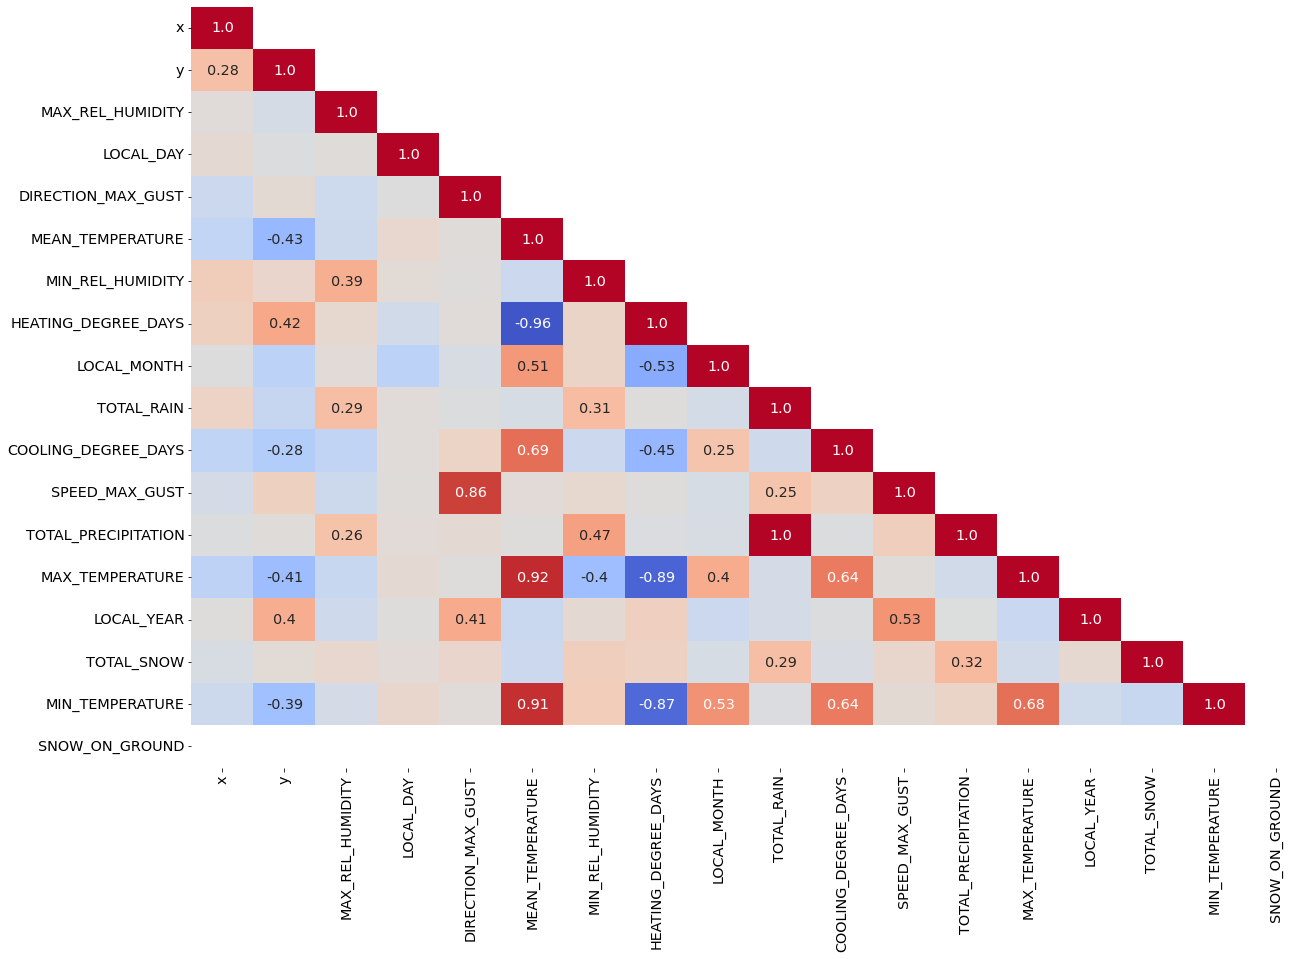

In [57]:
def customized_heatmap(df):
    corr_df = df.corr()
# Get only half portion of corr_df to avoid df, so create mask    
    mask = np.triu(np.ones_like(corr_df), k=1)
    
     
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.25 < t < 0.25:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    #Save fig uncomment first
#     plt.savefig("Heatmap DF")
    plt.show()
customized_heatmap(merged_df2)

In [58]:
column_list = merged_df2.columns.tolist()
flag_list = []
for column in column_list:
    if 'FLAG' in column.split('_'):
        flag_list.append(column)
merged_df2.drop(columns=flag_list, inplace = True)

In [59]:
# We filled Nan's in these columns by 0 because NaN indicates it didn't happen. 
values = {"SNOW_ON_GROUND": 0, "TOTAL_RAIN": 0, "TOTAL_PRECIPITATION": 0, "TOTAL_SNOW": 0}
merged_df2.fillna(value=values, inplace = True)

### We filled NaN values for SNOW_ON_GROUND, TOTAL_RAIN, TOTAL_PRECIPITATION and TOTAL_SNOW with 0 because NaN values in these columns mean non-existency of snow or rain. 

### We have to fill other features as well. For this we apply aggregation for each column in col_to_be_filled list. We used mean() for mean temperature, min and max temperature. We used pchip interpolation for max and min relative humidity. In this blog http://www.dominicgiles.com/blog/files/5c35bfe77c55082fbc293feb8a26d81a-152.html they suggest to use pchip interpolation for relative humidity. They mention that weather stations interpolate the missing values too. So it is reasonable to use pchip interpolation for missing values. 

In [60]:
col_to_be_filled = ['MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'MAX_TEMPERATURE', 'MIN_REL_HUMIDITY', 'MAX_REL_HUMIDITY', 
                   'SPEED_MAX_GUST','DIRECTION_MAX_GUST']
merged_df3= (
                merged_df2
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(MEAN_TEMPERATURE= lambda x: np.where(x.MEAN_TEMPERATURE.isna(), 
                                                                                 np.mean(x.MEAN_TEMPERATURE), 
                                                                                 x.MEAN_TEMPERATURE)))
            )

In [61]:
merged_df4= (
                merged_df3
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(MIN_TEMPERATURE= lambda x: np.where(x.MIN_TEMPERATURE.isna(), 
                                                                                np.mean(x.MIN_TEMPERATURE), 
                                                                                x.MIN_TEMPERATURE)))
            )

In [62]:
merged_df5= (
                merged_df4
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(MAX_TEMPERATURE= lambda x: np.where(x.MAX_TEMPERATURE.isna(), 
                                                                                np.mean(x.MAX_TEMPERATURE), 
                                                                                x.MAX_TEMPERATURE)))
            )

In [63]:
merged_df6= (
                merged_df5
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(MIN_REL_HUMIDITY= lambda x: np.where(x.MIN_REL_HUMIDITY.isna(), 
                                                                                 x.MIN_REL_HUMIDITY.interpolate(method='pchip',limit_direction = 'both'), 
                                                                                 x.MIN_REL_HUMIDITY)))
            )

In [64]:
merged_df7= (
                merged_df6
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(MAX_REL_HUMIDITY= lambda x: np.where(x.MAX_REL_HUMIDITY.isna(), 
                                                                                 x.MAX_REL_HUMIDITY.interpolate(method='pchip',limit_direction = 'both'), 
                                                                                 x.MAX_REL_HUMIDITY)))
            )

In [132]:
merged_df8= (
                merged_df7
                .groupby(['FireLocation'])
                .apply(lambda df: df.assign(SPEED_MAX_GUST= lambda x: np.where(x.SPEED_MAX_GUST.isna(), 
                                                                               np.mean(x.SPEED_MAX_GUST), 
                                                                               x.SPEED_MAX_GUST)))
            )

### We see that the number of missing values has been significantly reduced. Again, yellows represent missing values. 

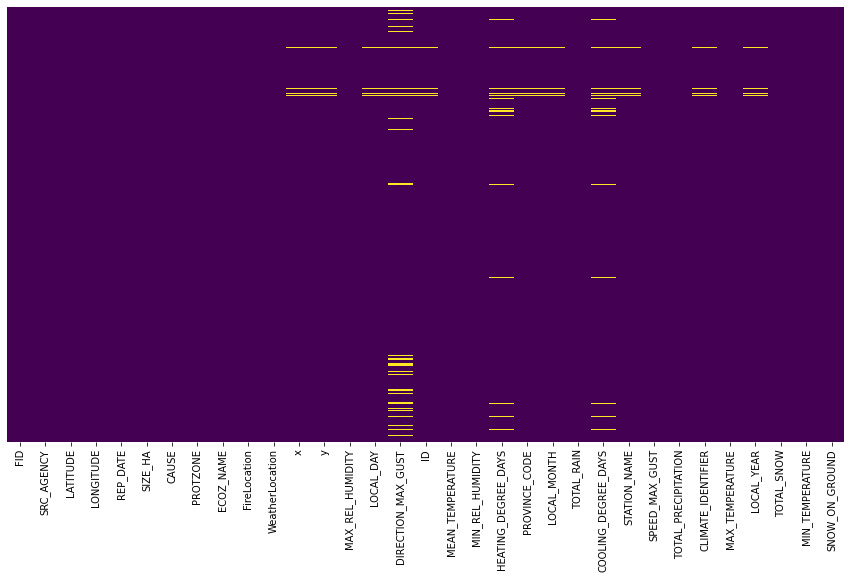

In [134]:
plt.figure(figsize=(15,8))
ax =sns.heatmap(merged_df8.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

### Definition of degree days and degree days is the following: Degree days are based on the assumption that when the outside temperature is 18 celsius we don't need heating or cooling to  be comfortable. Degree days are the difference between the daily temperature mean and 18 celsius.  Source: https://www.weather.gov/key/climate_heat_cool It is also obvious from correlation map that degree days are highly correlated with max and min temperature. So we can also remove them.

In [135]:
merged_df8.drop(columns=['HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS'], axis =1, inplace = True)

In [136]:
merged_df8.columns

Index(['FID', 'SRC_AGENCY', 'LATITUDE', 'LONGITUDE', 'REP_DATE', 'SIZE_HA',
       'CAUSE', 'PROTZONE', 'ECOZ_NAME', 'FireLocation', 'WeatherLocation',
       'x', 'y', 'MAX_REL_HUMIDITY', 'LOCAL_DAY', 'DIRECTION_MAX_GUST', 'ID',
       'MEAN_TEMPERATURE', 'MIN_REL_HUMIDITY', 'PROVINCE_CODE', 'LOCAL_MONTH',
       'TOTAL_RAIN', 'STATION_NAME', 'SPEED_MAX_GUST', 'TOTAL_PRECIPITATION',
       'CLIMATE_IDENTIFIER', 'MAX_TEMPERATURE', 'LOCAL_YEAR', 'TOTAL_SNOW',
       'MIN_TEMPERATURE', 'SNOW_ON_GROUND'],
      dtype='object')

### Filling DIRECTION_MAX_GUST is really tricky as direction is mostly affected by environment, e.g, height, mountains, trees etc. So it is better to drop it too. 

In [137]:
merged_df8.drop(columns=['DIRECTION_MAX_GUST'], axis =1, inplace = True)

### Now what we have to do is we have to aggregate all values of 15 days of data before the fire into the fire row. We have to be choose appropriate aggregation methods for each feature. For example it is better to use min or max for temperature whereas it is better to use sum for total rain and snow. 

In [148]:
merged_df8_copy = merged_df8.copy()
groupby_max_max_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'MAX_TEMPERATURE':'max'})
)
for i in range(int(len(groupby_max_max_df))):
    merged_df8['MAX_TEMPERATURE'].replace(merged_df8.iloc[15*i]['MAX_TEMPERATURE'],groupby_max_max_df.iloc[i]['MAX_TEMPERATURE'],inplace =True)
    

In [149]:
groupby_min_min_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'MIN_TEMPERATURE':'min'})
)
for i in range(int(len(groupby_min_min_df))):
    merged_df8['MIN_TEMPERATURE'].replace(merged_df8.iloc[15*i]['MIN_TEMPERATURE'],groupby_min_min_df.iloc[i]['MIN_TEMPERATURE'],inplace =True)

In [150]:
groupby_mean_mean_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'MEAN_TEMPERATURE':'mean'})
)
for i in range(int(len(groupby_mean_mean_df))):
    merged_df8['MEAN_TEMPERATURE'].replace(merged_df8.iloc[15*i]['MEAN_TEMPERATURE'],groupby_mean_mean_df.iloc[i]['MEAN_TEMPERATURE'],inplace =True)

In [151]:
groupby_min_humid_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'MIN_REL_HUMIDITY':'mean'})
)
for i in range(int(len(groupby_min_humid_df))):
    merged_df8['MIN_REL_HUMIDITY'].replace(merged_df8.iloc[15*i]['MIN_REL_HUMIDITY'],groupby_min_humid_df.iloc[i]['MIN_REL_HUMIDITY'],inplace =True)

In [152]:
groupby_max_humid_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'MAX_REL_HUMIDITY':'mean'})
)
for i in range(int(len(groupby_min_humid_df))):
    merged_df8['MAX_REL_HUMIDITY'].replace(merged_df8.iloc[15*i]['MAX_REL_HUMIDITY'],groupby_max_humid_df.iloc[i]['MAX_REL_HUMIDITY'],inplace =True)

In [153]:
groupby_total_rain_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'TOTAL_RAIN':'sum'})
)
for i in range(int(len(groupby_total_rain_df))):
    merged_df8['TOTAL_RAIN'].replace(merged_df8.iloc[15*i]['TOTAL_RAIN'],groupby_total_rain_df.iloc[i]['TOTAL_RAIN'],inplace =True)

In [154]:
groupby_total_snow_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'TOTAL_SNOW':'sum'})
)
for i in range(int(len(groupby_total_snow_df))):
    merged_df8['TOTAL_SNOW'].replace(merged_df8.iloc[15*i]['TOTAL_SNOW'],groupby_total_snow_df.iloc[i]['TOTAL_SNOW'],inplace =True)

In [155]:
groupby_total_prep_df = (
    merged_df8_copy
    .groupby(['FireLocation'])
    .agg({'TOTAL_PRECIPITATION':'sum'})
)
for i in range(int(len(groupby_total_prep_df))):
    merged_df8['TOTAL_PRECIPITATION'].replace(merged_df8.iloc[15*i]['TOTAL_PRECIPITATION'],groupby_total_prep_df.iloc[i]['TOTAL_PRECIPITATION'],inplace =True)

In [156]:
remove_index = [index for index in merged_df8.index if index%15!=0]

In [157]:
merged_df8.drop(remove_index, inplace = True)

### Now the fire dataset is ready to use. We have to add a class column. Remember that this notebook only creates the data where fire occured. We also need a non-fire dataset. This will be done in another notebook, namely "Fire data with class 0". 


In [158]:
fire_1_df = merged_df8.copy().reset_index()
fire_1_df

,index,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,...,TOTAL_RAIN,STATION_NAME,SPEED_MAX_GUST,TOTAL_PRECIPITATION,CLIMATE_IDENTIFIER,MAX_TEMPERATURE,LOCAL_YEAR,TOTAL_SNOW,MIN_TEMPERATURE,SNOW_ON_GROUND
0,0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,...,0.0,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0
1,15,328421,QC,52.573,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,...,0.0,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0
2,120,328451,QC,49.1275,-65.2352,2019-07-28,0.0,L,intensive,Atlantic Maritime,...,0.0,CAP-MADELEINE,46.000000,26.1,7051163,27.5,2019.0,0.0,-3.1,0.0
3,225,328573,QC,48.7306,-64.9126,2019-07-28,0.3,L,intensive,Atlantic Maritime,...,0.0,GASPE A,46.000000,26.1,7052601,27.5,2019.0,0.0,-2.2,0.0
4,345,328876,QC,53.0048,-77.4008,2019-07-01,25.5,L,nordique,Taiga Shield East,...,0.0,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,16695,371372,QC,55.3554,-76.0912,2021-07-05,26858.9,L,nordique,Taiga Shield East,...,0.0,UMIUJAQ A,82.000000,26.1,7108564,27.5,2021.0,0.0,-2.2,0.0
253,16725,371382,QC,49.7934,-78.9444,2021-07-17,3.0,L,intensive,Boreal Shield East,...,0.0,MATAGAMI,50.000000,26.1,7094637,27.5,2021.0,0.0,-2.2,0.0
254,16815,371401,QC,48.7492,-72.7857,2021-08-06,0.1,L,intensive,Boreal Shield East,...,0.0,NORMANDIN,44.000000,26.1,7065639,27.5,2021.0,0.0,-2.2,0.0
255,16905,371444,QC,49.1904,-76.6467,2021-08-19,0.2,L,intensive,Boreal Shield East,...,0.0,MATAGAMI,39.363636,26.1,7094637,27.5,2021.0,0.0,-2.2,0.0


In [159]:
fire_1_df.drop(columns = 'index' ,axis=1, inplace = True)

In [160]:
fire_1_df['Class'] = np.ones(len(fire_1_df))

In [161]:
fire_1_df

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,FireLocation,...,STATION_NAME,SPEED_MAX_GUST,TOTAL_PRECIPITATION,CLIMATE_IDENTIFIER,MAX_TEMPERATURE,LOCAL_YEAR,TOTAL_SNOW,MIN_TEMPERATURE,SNOW_ON_GROUND,Class
0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,"(52.5747, -76.52129999999998)",...,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0
1,328421,QC,52.573,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,"(52.573, -76.54179999999998)",...,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0
2,328451,QC,49.1275,-65.2352,2019-07-28,0.0,L,intensive,Atlantic Maritime,"(49.1275, -65.2352)",...,CAP-MADELEINE,46.000000,26.1,7051163,27.5,2019.0,0.0,-3.1,0.0,1.0
3,328573,QC,48.7306,-64.9126,2019-07-28,0.3,L,intensive,Atlantic Maritime,"(48.7306, -64.9126)",...,GASPE A,46.000000,26.1,7052601,27.5,2019.0,0.0,-2.2,0.0,1.0
4,328876,QC,53.0048,-77.4008,2019-07-01,25.5,L,nordique,Taiga Shield East,"(53.0048, -77.4008)",...,LA GRANDE RIVIERE A,39.000000,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,371372,QC,55.3554,-76.0912,2021-07-05,26858.9,L,nordique,Taiga Shield East,"(55.3554, -76.0912)",...,UMIUJAQ A,82.000000,26.1,7108564,27.5,2021.0,0.0,-2.2,0.0,1.0
253,371382,QC,49.7934,-78.9444,2021-07-17,3.0,L,intensive,Boreal Shield East,"(49.7934, -78.9444)",...,MATAGAMI,50.000000,26.1,7094637,27.5,2021.0,0.0,-2.2,0.0,1.0
254,371401,QC,48.7492,-72.7857,2021-08-06,0.1,L,intensive,Boreal Shield East,"(48.7492, -72.7857)",...,NORMANDIN,44.000000,26.1,7065639,27.5,2021.0,0.0,-2.2,0.0,1.0
255,371444,QC,49.1904,-76.6467,2021-08-19,0.2,L,intensive,Boreal Shield East,"(49.1904, -76.64669999999998)",...,MATAGAMI,39.363636,26.1,7094637,27.5,2021.0,0.0,-2.2,0.0,1.0


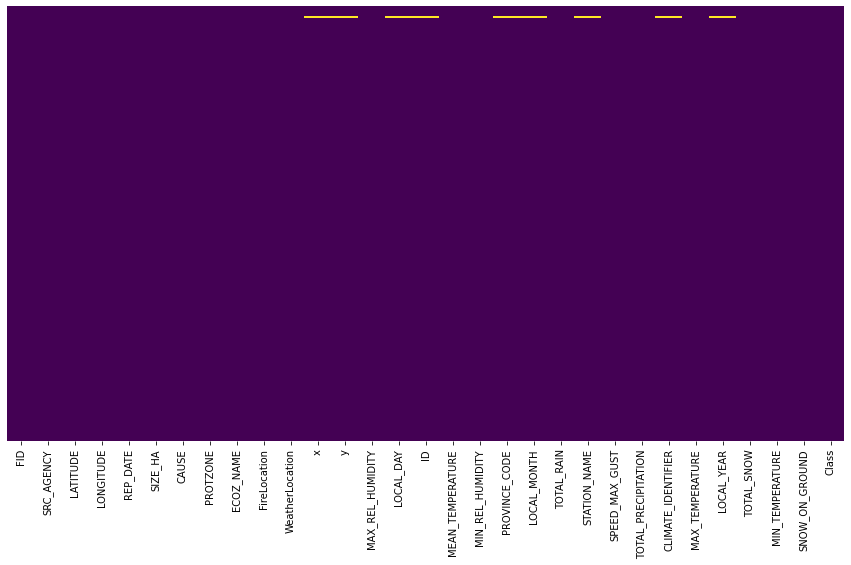

In [162]:
plt.figure(figsize=(15,8))
ax =sns.heatmap(fire_1_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()
# As we can see there are some features that is almost full of NaNs. Especially the ones with FLAG.
# It is because they put flag for some special days and the special days are rare. 